# Supervise ai trainning
Part 1: Can AI able to differnciate q/nq?

1. Load and spit the files

In [37]:
import pandas as pd
import ast

# Load full dataset
df = pd.read_csv("N_1000_filtered_train_data_with_features.csv")

# Define labels that are questions
question_labels = {'yn', 'wh', 'imp'}

# Sample with all columns preserved
yn_df = df[df['label'] == 'yn']
wh_df = df[df['label'] == 'wh'].sample(n=min(100, len(df[df['label'] == 'wh'])), random_state=42)
imp_df = df[df['label'] == 'imp'].sample(n=min(100, len(df[df['label'] == 'imp'])), random_state=42)
nq_df = df[df['label'] == 'nq'].sample(n=295, random_state=42)

# Combine them
balanced_df = pd.concat([yn_df, wh_df, imp_df, nq_df])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Assign binary label: question (1) vs. not-question (0)
balanced_df['binary_label'] = balanced_df['label'].apply(lambda x: 1 if x in question_labels else 0)

# Parse MFCCs
balanced_df['mfcc_means'] = balanced_df['mfcc_means'].apply(ast.literal_eval)

# Optional: check counts
print(balanced_df['binary_label'].value_counts())


binary_label
0    295
1    295
Name: count, dtype: int64


2. Preprocess Text and Split Data

In [39]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import sparse

# 1. Vectorize text
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(balanced_df['text'])

# 2. Extract dense acoustic features
numeric_features = balanced_df[[
    'word_count', 'f0_mean', 'f0_std', 'f0_end_slope',
    'energy_mean', 'energy_std', 'zcr_mean'
]].values

mfcc_features = np.array(balanced_df['mfcc_means'].tolist())

# 3. Combine numeric + MFCCs
dense_features = np.hstack([numeric_features, mfcc_features])

# 4. Scale the dense features (insert this here!)
scaler = StandardScaler()
scaled_dense = scaler.fit_transform(dense_features)

# 5. Convert scaled dense to sparse, and combine with text
dense_sparse = sparse.csr_matrix(scaled_dense)
X = hstack([text_features, dense_sparse])

# 6. Labels
y = balanced_df['binary_label']


3. Train a Classifier

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85        59
           1       0.84      0.88      0.86        59

    accuracy                           0.86       118
   macro avg       0.86      0.86      0.86       118
weighted avg       0.86      0.86      0.86       118

Confusion Matrix:
 [[49 10]
 [ 7 52]]


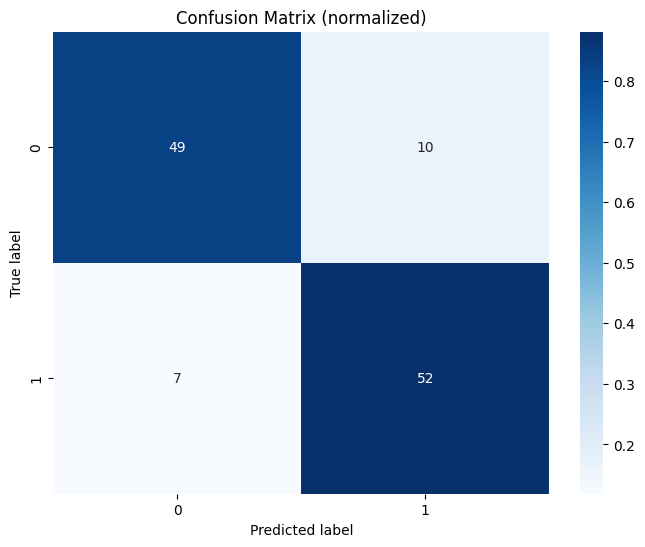

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y
)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# Use seaborn for visualization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Compute the raw confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2. (Optional) Normalize it so each row sums to 1
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,               # or cm if you want counts
    annot=cm,              # show raw counts in the boxes
    fmt='d',               # integer format for counts
    cmap='Blues',          # choose a colormap you like
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.title("Confusion Matrix (normalized)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()







# K-fold classification

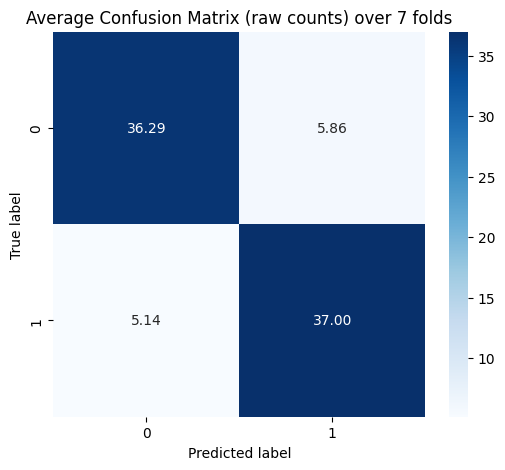

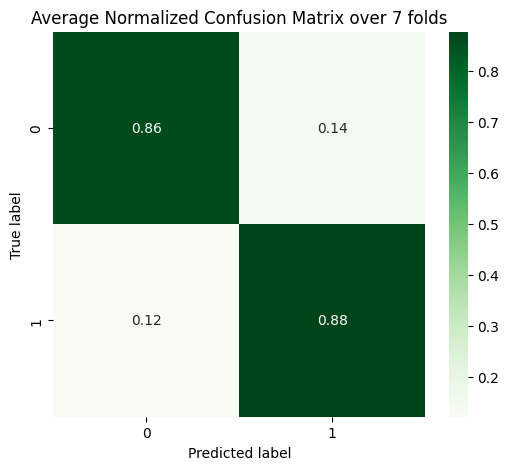

 Accuracy: 0.875 ± 0.041
Precision: 0.875 ± 0.055
   Recall: 0.878 ± 0.049
       F1: 0.875 ± 0.039


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# assume X, y are ready
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
classes = np.unique(y)

# placeholders for sums
cm_sum      = np.zeros((len(classes), len(classes)), dtype=int)
cm_norm_sum = np.zeros((len(classes), len(classes)), dtype=float)

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf = LogisticRegression(max_iter=5000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # raw confusion matrix (fixed label order)
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_sum += cm
    
    # normalized (row-wise) for this fold
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm_sum += cm_norm

# Number of folds
k = 7

# 1) Average raw counts per fold
cm_avg_raw = cm_sum / k

# 2) Average normalized matrix
cm_avg_norm = cm_norm_sum / k

# ---- Plot average raw CM ----
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_avg_raw,
    annot=True,
    fmt='.2f',           # show fractional averages
    cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)
plt.title("Average Confusion Matrix (raw counts) over 7 folds")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# ---- Plot average normalized CM ----
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_avg_norm,
    annot=True,
    fmt='.2f',           # average % per cell
    cmap='Greens',
    xticklabels=classes,
    yticklabels=classes
)
plt.title("Average Normalized Confusion Matrix over 7 folds")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


# Automatically evaluate the model using cross-validation
from sklearn.model_selection import cross_validate

clf = LogisticRegression(max_iter=5000)
scoring = ['accuracy', 'precision', 'recall', 'f1']

scores = cross_validate(
    clf, X, y,
    cv=7,
    scoring=scoring,
    return_train_score=False
)

# Print mean and std for each metric
for metric in scoring:
    m = scores[f'test_{metric}']
    print(f"{metric.capitalize():>9}: {m.mean():.3f} ± {m.std():.3f}")



# Decision boundary

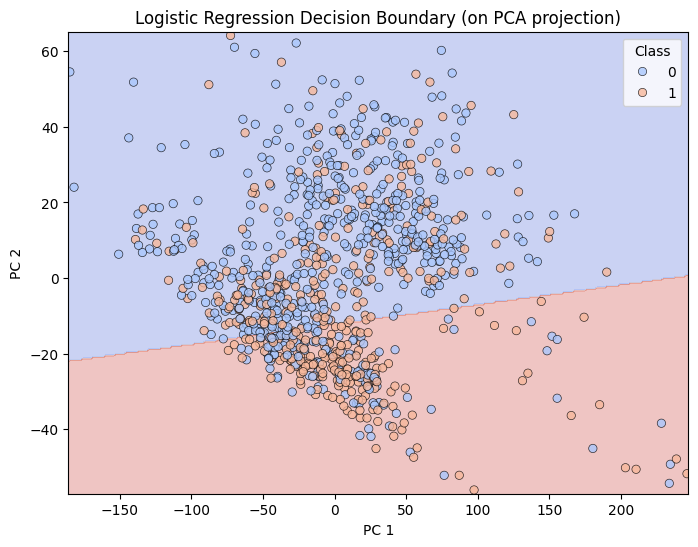

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# 1. Project to 2D
# If X is sparse, convert to dense for PCA
X_dense = X.toarray() if hasattr(X, "toarray") else X
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_dense)

# 2. Train a new 2D logistic
clf2 = LogisticRegression(max_iter=5000)
clf2.fit(X2, y)

# 3. Create a mesh over the PC space
x_min, x_max = X2[:,0].min() - 1, X2[:,0].max() + 1
y_min, y_max = X2[:,1].min() - 1, X2[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

# 4. Predict on the grid
grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf2.predict(grid).reshape(xx.shape)

# 5. Plot
plt.figure(figsize=(8,6))
# decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
# scatter the actual points
sns.scatterplot(
    x=X2[:,0], y=X2[:,1],
    hue=y,
    palette='coolwarm',
    edgecolor='k',
    alpha=0.8
)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Logistic Regression Decision Boundary (on PCA projection)")
plt.legend(title="Class")
plt.show()


# Model exclude text

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.66      0.66        59
           1       0.66      0.64      0.65        59

    accuracy                           0.65       118
   macro avg       0.65      0.65      0.65       118
weighted avg       0.65      0.65      0.65       118

Confusion Matrix:
 [[39 20]
 [21 38]]


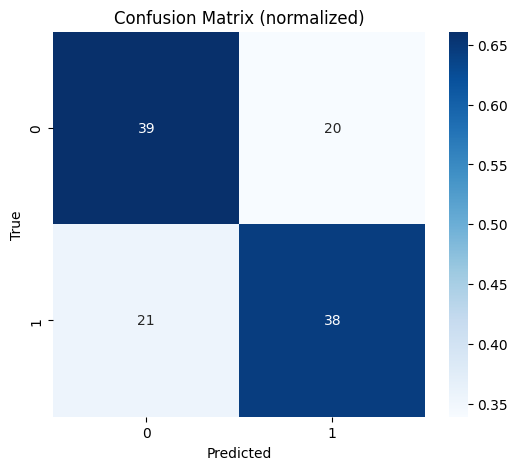

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract dense acoustic + numeric features
numeric_features = balanced_df[[
    'word_count', 'f0_mean', 'f0_std', 'f0_end_slope',
    'energy_mean', 'energy_std', 'zcr_mean'
]].values
mfcc_features = np.vstack(balanced_df['mfcc_means'].values)

dense = np.hstack([numeric_features, mfcc_features])

# 2. Scale them
scaler = StandardScaler()
scaled_dense = scaler.fit_transform(dense)

# 3. (Optional) convert to sparse if you want to save memory
X = csr_matrix(scaled_dense)

# 4. Labels
y = balanced_df['binary_label']

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5757, stratify=y
)

# 6. Fit a classifier
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)

# 7. Evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 8. Plot normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (normalized)")
plt.show()


# how about only text

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        59
           1       0.84      0.92      0.88        59

    accuracy                           0.87       118
   macro avg       0.88      0.87      0.87       118
weighted avg       0.88      0.87      0.87       118

Confusion Matrix:
 [[49 10]
 [ 5 54]]


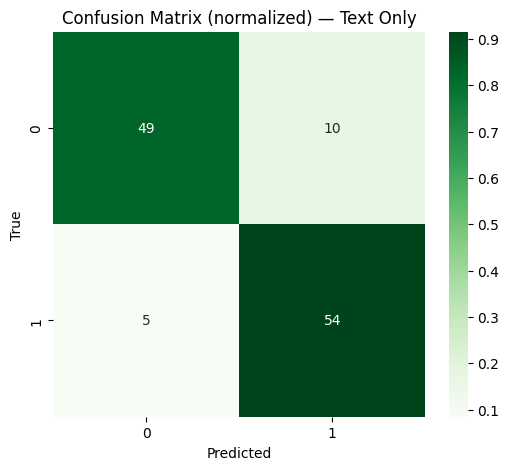

In [41]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Vectorize text only
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(balanced_df['text'])

# 2. Labels
y = balanced_df['binary_label']

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y
)

# 4. Fit classifier
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)

# 5. Predict & evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 6. Plot normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Greens',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (normalized) — Text Only")
plt.show()


# Dummy Classifer
Is the model not randomly gussing?

In [32]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1) Uniform random baseline
rnd_clf = DummyClassifier(strategy='uniform', random_state=68585)

# 2) Or, stratified random baseline
# rnd_clf = DummyClassifier(strategy='stratified', random_state=42)

rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.46      0.50       114
           1       0.40      0.47      0.43        86

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.46       200
weighted avg       0.48      0.47      0.47       200

Confusion Matrix:
 [[53 61]
 [46 40]]


# 7-fold CV

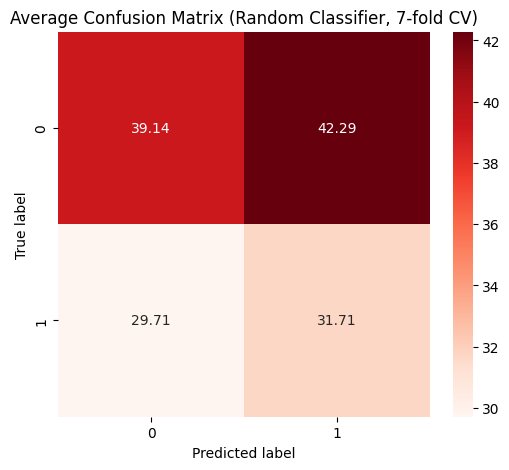

In [27]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=777)
classes = np.unique(y)

# placeholders
cm_sum = np.zeros((len(classes), len(classes)), dtype=int)

for train_idx, test_idx in kf.split(X, y):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    
    # pick your random strategy:
    rnd = DummyClassifier(strategy='uniform', random_state=777)
    # rnd = DummyClassifier(strategy='stratified', random_state=42)
    
    rnd.fit(X_tr, y_tr)
    y_pr = rnd.predict(X_te)
    
    cm = confusion_matrix(y_te, y_pr, labels=classes)
    cm_sum += cm

# average per fold
cm_avg = cm_sum / 7.0

# plot
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_avg,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    xticklabels=classes,
    yticklabels=classes
)
plt.title("Average Confusion Matrix (Random Classifier, 7‑fold CV)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


# Trying with audio
Dimensionality of the audio will be reduced by PCA

In [21]:
import pandas as pd
import numpy as np
import librosa
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.sparse import hstack, csr_matrix

# === Load Dataset ===
df = pd.read_csv("N_1000_filtered_train_data.csv")  # Change to your CSV filename

# Binary label: 1 if it's a question (yn, wh, imp), else 0
question_labels = {'yn', 'wh', 'imp'}
df['binary_label'] = df['label'].apply(lambda x: 1 if x in question_labels else 0)

# === Extract MFCC Audio Features ===
audio_features = []

for path in df['audio_path']:
    try:
        y, sr = librosa.load(path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_mean = np.mean(mfcc, axis=1)  # shape: (40,)
        audio_features.append(mfcc_mean)
    except Exception as e:
        print(f"Error with {path}: {e}")
        audio_features.append(np.zeros(40))

audio_features = np.array(audio_features)

# === Reduce or Pad to 128 Dimensions ===
if audio_features.shape[1] < 128:
    pad_width = 128 - audio_features.shape[1]
    audio_features = np.hstack([audio_features, np.zeros((audio_features.shape[0], pad_width))])
else:
    pca = PCA(n_components=128, random_state=42)
    audio_features = pca.fit_transform(audio_features)

# === Text Features (TF-IDF) ===
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(df['text'])

# === Combine Audio + Text Features ===
X = hstack([text_features, csr_matrix(audio_features)])
y = df['binary_label']

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Train Model ===
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# === Evaluate ===
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.81      0.81       114
           1       0.74      0.74      0.74        86

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



# autoencoder

In [44]:
import pandas as pd
import numpy as np
import librosa
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.sparse import hstack, csr_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# === Load Dataset ===
df = pd.read_csv("N_1000_filtered_train_data.csv")
question_labels = {'yn', 'wh', 'imp'}
df['binary_label'] = df['label'].apply(lambda x: 1 if x in question_labels else 0)

# === Extract MFCC Audio Features ===
audio_features = []
for path in df['audio_path']:
    try:
        y, sr = librosa.load(path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_mean = np.mean(mfcc, axis=1)
        audio_features.append(mfcc_mean)
    except Exception as e:
        print(f"Error with {path}: {e}")
        audio_features.append(np.zeros(40))
audio_features = np.array(audio_features)

# === Autoencoder for Dimensionality Reduction ===
class Autoencoder(nn.Module):
    def __init__(self, input_dim=40, encoded_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Prepare Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
features_tensor = torch.tensor(audio_features, dtype=torch.float32)
dataset = TensorDataset(features_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train Autoencoder
model = Autoencoder(input_dim=40, encoded_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

model.train()
for epoch in range(30):
    total_loss = 0
    for batch in loader:
        x = batch[0].to(device)
        encoded, decoded = model(x)
        loss = criterion(decoded, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Encode audio features
model.eval()
with torch.no_grad():
    encoded_audio = model.encoder(features_tensor.to(device)).cpu().numpy()

# === Text Features (TF-IDF) ===
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(df['text'])

# === Combine Audio + Text Features ===
X = hstack([text_features, csr_matrix(encoded_audio)])
y = df['binary_label']

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Train Model ===
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# === Evaluate ===
print(classification_report(y_test, y_pred))


Epoch 1, Loss: 16799.1369
Epoch 2, Loss: 1647.1650
Epoch 3, Loss: 1114.4494
Epoch 4, Loss: 665.8894
Epoch 5, Loss: 432.2747
Epoch 6, Loss: 326.0353
Epoch 7, Loss: 301.0937
Epoch 8, Loss: 280.0650
Epoch 9, Loss: 266.6826
Epoch 10, Loss: 243.0367
Epoch 11, Loss: 222.5237
Epoch 12, Loss: 204.8383
Epoch 13, Loss: 183.4500
Epoch 14, Loss: 168.9753
Epoch 15, Loss: 156.1838
Epoch 16, Loss: 138.0923
Epoch 17, Loss: 126.1917
Epoch 18, Loss: 116.1145
Epoch 19, Loss: 107.3505
Epoch 20, Loss: 98.4368
Epoch 21, Loss: 95.4625
Epoch 22, Loss: 90.7028
Epoch 23, Loss: 83.9899
Epoch 24, Loss: 79.2969
Epoch 25, Loss: 75.1133
Epoch 26, Loss: 70.8243
Epoch 27, Loss: 66.1922
Epoch 28, Loss: 65.0117
Epoch 29, Loss: 61.6156
Epoch 30, Loss: 58.3446
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       114
           1       0.74      0.74      0.74        86

    accuracy                           0.78       200
   macro avg       0.77      0.77      0.77     

# Text only

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume you've already:
# 1) Loaded df and created df['binary_label']
# 2) Extracted raw MFCCs into `audio_features` (shape [N,40])
# 3) Trained your Autoencoder and computed:
#       encoded_audio = model.encoder(torch.tensor(audio_features)).cpu().numpy()
#
# Now we build the “audio‑only” model:

# 1. (Optional) Scale the encoded features
scaler = StandardScaler()
X = scaler.fit_transform(encoded_audio)    # shape [N, encoded_dim]

# 2. Labels
y = df['binary_label'].values

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Train a simple classifier
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)

# 5. Evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 6. (Optional) Plot normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Oranges',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (normalized) — Audio Only")
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(encoded_audio)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['binary_label'], cmap='coolwarm', alpha=0.7)
plt.title("t-SNE of Encoded Audio Features")
plt.colorbar(label="Question Label (0=Non, 1=Question)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()
